In [1]:
%load_ext autoreload
%autoreload 2

# data processing
import pandas as pd
import numpy as np
from datetime import datetime
from datetime import timedelta

# plotting
import seaborn as sns
import matplotlib.pyplot as plt

# sklearn for preprocessing
import sklearn.metrics as skm
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

# tensorflow for model building
import tensorflow as tf
from tensorflow.keras import layers, models


2023-12-17 15:58:58.949363: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-17 15:58:58.972972: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-17 15:58:59.149399: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-17 15:58:59.149576: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-17 15:58:59.179343: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

In [2]:
# custom functions
from nn_helpers import *

## Load the training data
This is the clean data that we processed in the notebook `Training_data_preparation`

In [3]:
data_path = "DATA/training_data/"

df = pd.read_csv(data_path + "VEX_edac_mag_labeled.csv")

In [4]:
df.head()

,DATE_TIME,EDAC,BX,BY,BZ,BT,XSC,YSC,ZSC,RSC,cme
0,2006-04-24 00:00:00,0,12.357658,-1.304164,-3.332425,12.881274,-4451.055178,-3196.485753,-65466.762260,65695.760575,0
1,2006-04-24 00:05:00,0,12.868947,-0.980800,-3.360027,13.340680,-4202.246280,-3138.377907,-65806.350827,66015.078600,0
2,2006-04-24 00:10:00,0,12.857438,-0.871986,-3.487877,13.355384,-3954.000329,-3080.233288,-66137.913808,66327.612616,0
3,2006-04-24 00:15:00,0,12.898635,-0.684986,-2.885689,13.248405,-3705.057257,-3021.761270,-66463.291041,66635.079608,0
4,2006-04-24 00:20:00,0,12.766473,-0.517608,-2.217135,12.972905,-3453.676541,-2962.553108,-66784.717784,66939.596338,0


We separate the feature matrix `X` and the labels `y`.
- `X1` will only contain the time and EDAC data
- `X2` will contain the time, EDAC, and magneto data

In [6]:
y = df['cme'].values
X1 = df['EDAC'].values
X2 = df.drop(['cme'], axis=1).values
X3 = df['BT'].values

In [8]:
print("Shape of y:", y.shape)
print("Shape of X1:", X1.shape)
print("Shape of X2:", X2.shape)
print("Shape of X3:", X3.shape)

Shape of y: (893069,)
Shape of X1: (893069,)
Shape of X2: (893069, 10)
Shape of X3: (893069,)


## Class imbalance
Let's have a look at the class imbalance in our training data:

In [9]:
print('CME events in our data:')
print(df['cme'].value_counts())

cme_percentage = df['cme'].value_counts()[1] / len(df['cme']) * 100

# Print the percentage of CME events using f-strings and rounding to 2 decimal places
print(f'Percentage of CME events: {round(cme_percentage, 2)}%')

CME events in our data:
cme
0    877130
1     15939
Name: count, dtype: int64
Percentage of CME events: 1.78%


The proportion of CME events is very low: only 2% of our data corresponds to a CME.

Since we have this huge class imbalance, we can expect the models we will train to be biased towards predicting no CMEs.
We will have to implement various methods to mitigate this class imbalance later on.

## Feature correlation
We look at correlation between EDAC and CME features using:
- Pearson Correlation Coefficient: this measures the linear correlation between two variables. It ranges from -1 to +1, with -1 indicating a perfect negative linear correlation, +1 indicating a perfect positive linear correlation, and 0 indicating no linear correlation.
- Spearman's Rank Correlation: if the data is not normally distributed or the relationship is not linear, Spearman's rank correlation, which assesses monotonic relationships, might be more appropriate.

We will look at both

In [ ]:
pearson_corr, _ = pearsonr(df['EDAC'], df['cme'])
spearman_corr, _ = spearmanr(df['EDAC'], df['cme'])

In [ ]:
print(f"Pearson Correlation Coefficient: {pearson_corr}")
print(f"Spearman Correlation Coefficient: {spearman_corr}")

Pearson Correlation Coefficient: 0.013397539652011355
Spearman Correlation Coefficient: 0.009878111834817396


Both correlation coefficients are close to zero, indicating a very weak relationship between 'EDAC' and 'cme'.
- The Pearson correlation coefficient of approximately 0.0134 suggests that there is a negligible positive linear relationship between 'EDAC' and 'cme'.

- The Spearman correlation coefficient of approximately 0.0099 also indicates a very weak monotonic relationship between 'EDAC' and 'cme'.

Given these low correlation values, it's clear that EDAC counts alone have very little association with CME events. 

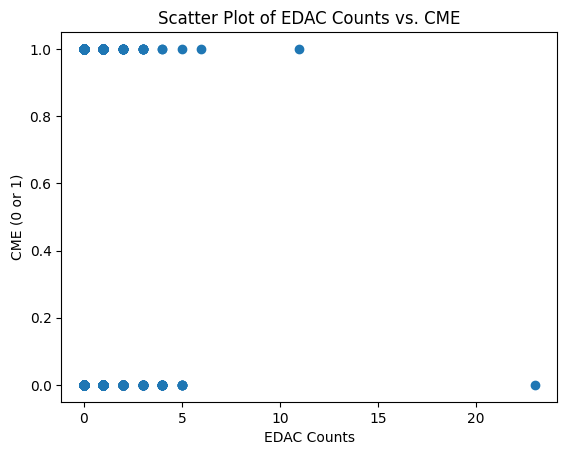

In [ ]:
plt.scatter(df['EDAC'], df['cme'])
plt.xlabel('EDAC Counts')
plt.ylabel('CME (0 or 1)')
plt.title('Scatter Plot of EDAC Counts vs. CME')
plt.show()

Trend Analysis: If there was a clear trend or pattern, such as a distinct increase in EDAC counts with the presence of CME events, it would be visible in the scatter plot. However, from this visualization, it doesn't appear that there is a strong and obvious linear relationship since the points for y=1 are not consistently higher in EDAC counts than those for y=0.

## The "dumb model"
First, let's look at a model that would always predict cme = 0.

This model will have a great accuracy (since CME events are very rare) but a F1 score of 0.

We will use this "dumb model" accuracy as an indicator for our next models's accuracy.

In [10]:
pred_dumb = np.zeros_like(y)

accuracy_dumb = skm.accuracy_score(y, pred_dumb)
f1_dumb = skm.f1_score(y, pred_dumb)

print_metrics('DUMB MODEL', y, pred_dumb)

Performance of DUMB MODEL:
Accuracy: 0.98
Precision: 0.0


/home/agatha/Anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Recall: 0.0
F1 score: 0.0


## Neural net models
We will buid a neural net that looks at EDAC activity in the previous `X` hours and predicts if there is a CME event going on.

We will try different values of `X`, our `window_size`:

In [11]:
window_sizes = [1, 3, 8, 24, 168, 720]
# 1 hour, 3 hours, 8 hours, 1 day, 1 week, 1 month

In [12]:
metrics_array = neural_net_comp(X1, y, window_sizes, epochs=5, batch_size=32)

5581/5581 [==============================] - 7s 1ms/step - loss: 0.7088 - accuracy: 0.5730 - precision_3: 0.0204 - recall_3: 0.5016 - f1_score: 0.0341


: 

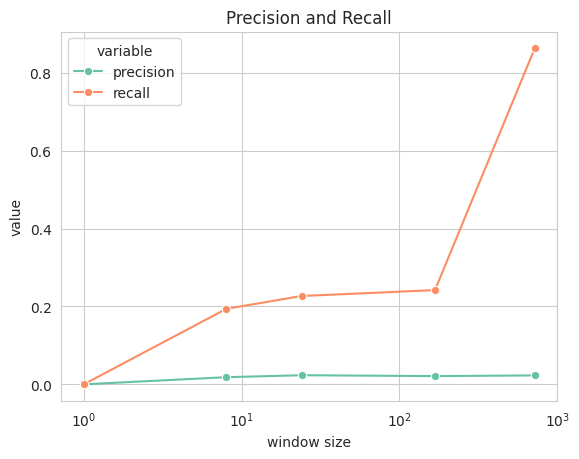

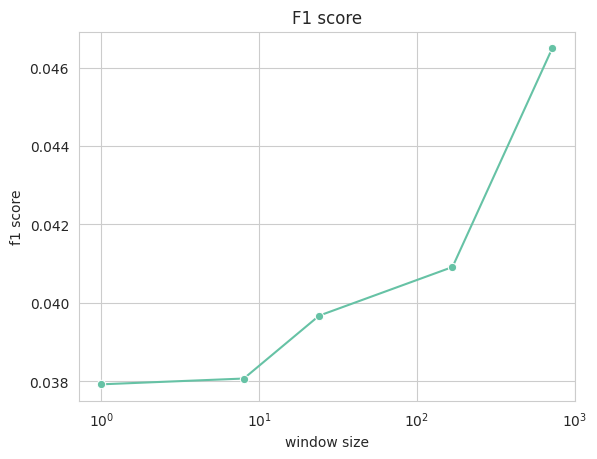

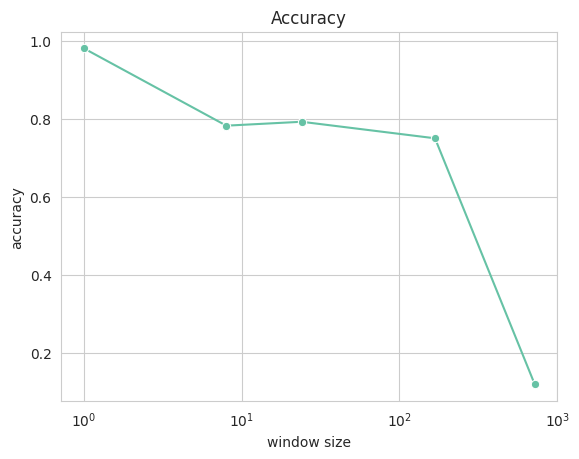

In [ ]:
plot_metrics(metrics_array, window_sizes)

#### Class imbalance: adding class weights
Our previous models get an accuracy similar to the "dumb model" but the F1 score (although non zero) is still very low.
- low precision indicates that the model is making a large number of false positives (it is pretty good when we fix `window_size` at 8 or 24 hours)
- low recall indicates that the model is missing a significant number of positive instances (always very low in all our models)

This is mainly due to the fact that we have a huge class imbalance (remember that only 2% of our data corresponds to a CME event).

To mitigate this, we will focus on `window_size=8` (best precision, accuracy and loss) and we will try to add class weights, to boost intances of the minority class in our training run.

In [ ]:
test_metrics_unbalanced = metrics_array[1]
# test metrics without class weights for window size 8

In [ ]:
test_metrics_balanced, _ = neural_net(X1, y, window_size=8, epochs=5, batch_size=32)

Epoch 1/5
1662/1662 [==============================] - 2s 1ms/step - loss: 0.1277 - accuracy: 0.9784 - precision_10: 0.2857 - recall_10: 0.0017 - f1_score: 0.0418
Epoch 2/5
1662/1662 [==============================] - 2s 1ms/step - loss: 0.1050 - accuracy: 0.9784 - precision_10: 0.3077 - recall_10: 0.0035 - f1_score: 0.0421
Epoch 3/5
1662/1662 [==============================] - 2s 1ms/step - loss: 0.1036 - accuracy: 0.9785 - precision_10: 0.5333 - recall_10: 0.0070 - f1_score: 0.0421
Epoch 4/5
1662/1662 [==============================] - 2s 1ms/step - loss: 0.1038 - accuracy: 0.9784 - precision_10: 0.4286 - recall_10: 0.0079 - f1_score: 0.0421
Epoch 5/5
416/416 [==============================] - 0s 822us/step - loss: 0.0951 - accuracy: 0.9805 - precision_10: 0.4000 - recall_10: 0.0078 - f1_score: 0.0381


In [ ]:
print(test_metrics_unbalanced)
print(test_metrics_balanced)

[0.7004299163818359, 0.7823994159698486, 0.018281536176800728, 0.19379845261573792, 0.03807275]
[0.09513907879590988, 0.9805189967155457, 0.4000000059604645, 0.007751937955617905, 0.03807275]


In [ ]:
print_improvement(test_metrics_balanced, test_metrics_unbalanced, 'class weights')

Performance of the model with class weights:
Loss: 0.1
Accuracy: 0.98
Precision: 0.4
Recall: 0.01
F1 score: 0.03999999910593033

Performance difference of the model with class weights:
Loss: -0.61
Accuracy: 0.2
Precision: 0.38
Recall: -0.19
F1 score: 0.0


We see that adding class weights leads to an better precision but lowers significantly the recall, thus giving the same F1 score. We have to try other approaches.

## Data augmentation
Let's try replicating the data points of the minority class (multipy by `X`):

In [ ]:
augmentation = 5

In [ ]:
test_metrics_1_aug, model_1 = neural_net(X1, y, window_size=8, epochs=5, batch_size=32, augmentation=augmentation)
test_metrics_2_aug, model_2 = neural_net_dim(X2, y, window_size=8, epochs=5, batch_size=32, augmentation=augmentation)

Epoch 1/5
176/176 [==============================] - 1s 1ms/step - loss: 0.2217 - accuracy: 0.9895 - precision_11: 1.0000 - recall_11: 0.9895 - f1_score: 1.0000
Epoch 2/5
176/176 [==============================] - 0s 1ms/step - loss: 0.0037 - accuracy: 1.0000 - precision_11: 1.0000 - recall_11: 1.0000 - f1_score: 1.0000
Epoch 3/5
176/176 [==============================] - 0s 1ms/step - loss: 9.0247e-04 - accuracy: 1.0000 - precision_11: 1.0000 - recall_11: 1.0000 - f1_score: 1.0000
Epoch 4/5
176/176 [==============================] - 0s 1ms/step - loss: 3.8510e-04 - accuracy: 1.0000 - precision_11: 1.0000 - recall_11: 1.0000 - f1_score: 1.0000
Epoch 5/5
44/44 [==============================] - 0s 847us/step - loss: 1.4282e-04 - accuracy: 1.0000 - precision_11: 1.0000 - recall_11: 1.0000 - f1_score: 1.0000
Epoch 1/5
176/176 [==============================] - 1s 1ms/step - loss: 13.2218 - accuracy: 0.9968 - precision_12: 1.0000 - recall_12: 0.9968 - f1_score: 0.9984
Epoch 2/5
176/176 [==

In [ ]:
print('Only EDAC feature:')
print_improvement(test_metrics_1_aug, test_metrics_unbalanced, 'augmentation')

Only EDAC feature:
Performance of the model with augmentation:
Loss: 0.0
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 score: 1.0

Performance difference of the model with augmentation:
Loss: -0.7
Accuracy: 0.22
Precision: 0.98
Recall: 0.81
F1 score: 0.9599999785423279


In [ ]:
print('EDAC and magneto features:')
print_improvement(test_metrics_2_aug, test_metrics_unbalanced, 'augmentation')

EDAC and magneto features:
Performance of the model with augmentation:
Loss: 0.0
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 score: 1.0

Performance difference of the model with augmentation:
Loss: -0.7
Accuracy: 0.22
Precision: 0.98
Recall: 0.81
F1 score: 0.9599999785423279


#### Plotting the predictions of our models:

In [ ]:
X1_series = create_series(X1, 8)
X2_series = create_series_dim(X2, 8)

true_label = y[7:]

prediction_1 = np.round(model_1.predict(X1_series)).flatten()
prediction_2 = np.round(model_2.predict(X2_series)).flatten()

2078/2078 [==============================] - 2s 980us/step


In [ ]:
print_metrics('Model 1', true_label, prediction_1)
print()
print_metrics('Model 2', true_label, prediction_2)

Performance of Model 1:
Accuracy: 0.02
Precision: 0.02
Recall: 1.0
F1 score: 0.04

Performance of Model 2:
Accuracy: 0.02
Precision: 0.02
Recall: 1.0
F1 score: 0.04


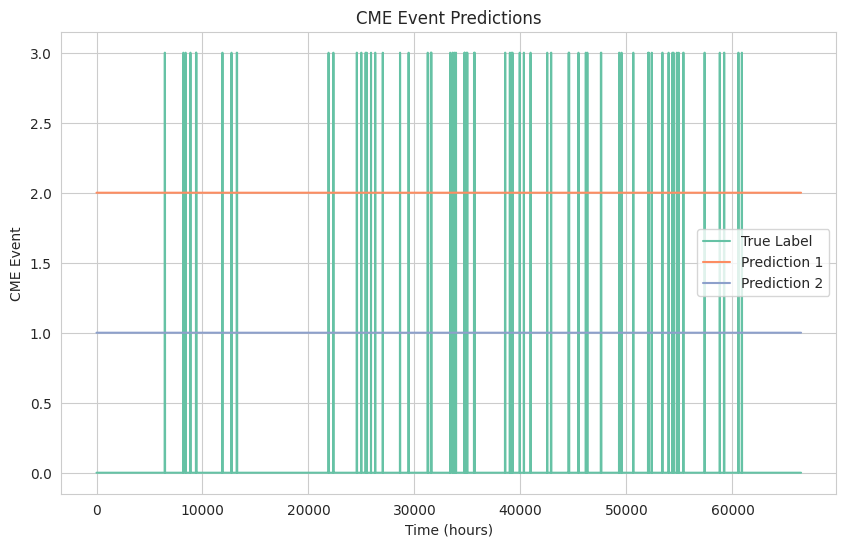

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(true_label*3, label='True Label')
plt.plot(prediction_1*2, label='Prediction 1')
plt.plot(prediction_2, label='Prediction 2')
plt.xlabel('Time (hours)')
plt.ylabel('CME Event')
plt.title('CME Event Predictions')
plt.legend()
plt.show()
